## Building a Multilayer Perceptron



Let's follow the lecture and build a multilayer perceptron to approximate the function $\theta(x)$ in our variational inference model $$\mathrm{Bernoulli}(z|\theta(x))$$ with the following structure

* 2 input nodes
* 2 internal features computed using ReLu activation
* 1 output feature with sigmoid activation that 

From Ex3, we had already the following code ready

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def linear(X,pars):
    out = X @ pars[:2].T + pars[2]
    grad_pars = np.column_stack([X,np.ones(len(X))])
    return out,grad_pars

def sigmoid(x):
    out = 1/(1+np.exp(-x))
    grad = out*(1-out)
    return out,grad.reshape(-1,1)

def theta_perceptron(X,pars):
    feature1,grad_linear1 = linear(X,pars[0:3])
    activation1,grad_sigmoid1 = sigmoid(feature1)
    return activation1, grad_sigmoid1*grad_linear1

* Write a function `relu(x)` that produces the relu activation function and its gradient.
* make sure the gradient is returned as a shape (N,1)
* plot it for the range: `x = np.linspace(-5,5,1001)`

In [2]:
def relu(x):
    out = np.where(x < 0, np.zeros_like(x),x)
    grad = np.where(x < 0, np.zeros_like(x),np.ones_like(x))
    return out,grad.reshape(-1,1)

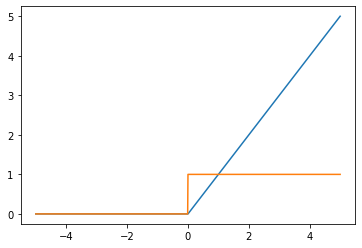

In [3]:
xi = np.linspace(-5,5,1001)
r,g = relu(xi)
plt.plot(xi,r)
plt.plot(xi,g)

Write a function `multilayer_perceptron(X,pars)` that takes 9 parameters (3 for each artificial neurons: 2 weights and 1 bias) that can compute the $\theta(x)$ prediction for many input points at once (batched computation)

In [4]:
def multilayer_perceptron(X,pars):
    feature1,grad_f1 = linear(X,pars[0:3])
    feature2,grad_f2 = linear(X,pars[3:6])
    activation1,grad_r1 = relu(feature1)
    activation2,grad_r2 = relu(feature2)
    hidden = np.column_stack([activation1,activation2])
    output_feature,grad_f3 = linear(hidden,pars[6:9])
    theta,grad_sig = sigmoid(output_feature)
    return theta

Use this function to plot the contour of the multilayer perceptron

```
def plot_contour(func,pars):
    grid = np.mgrid[-5:5:101j,-5:5:101j]
    X = np.swapaxes(grid,0,-1).reshape(-1,2)
    out = func(X,pars)
    out = np.swapaxes(out.reshape(101,101),0,-1)
    plt.contour(grid[0],grid[1],out)
```

Try for example parameter vectors: `np.array([1,0,0,0,1,0,1,1,0])` or what every you like.

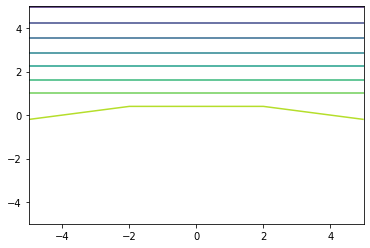

In [5]:
def plot_contour(func,pars):
    grid = np.mgrid[-5:5:101j,-5:5:101j]
    X = np.swapaxes(grid,0,-1).reshape(-1,2)
    out = func(X,pars)
    out = np.swapaxes(out.reshape(101,101),0,-1)
    plt.contour(grid[0],grid[1],out)
    
plot_contour(multilayer_perceptron,np.array([-.2,1,0.0,.2,1,0.0,-.1,-.1,0]))

Now comes the hard part!

We want to compute gradients for this function

$$
\vec{a} = [\;\mathrm{ReLU}(\mathrm{Lin}(\vec{x},\phi_1))\;,\;\mathrm{ReLU}(\mathrm{Lin}(\vec{x},\phi_2))\;]\\
a_2 = \sigma(\mathrm{Lin}(\vec{a},\phi_3))\\
$$

To compute the gradient we need to also have the gradients $\frac{\partial \mathrm{Lin}}{\partial \vec{x}}$

* Write a new function that also outputs the partial derivatives with respect to $\vec{x}$
* Hint: the output shape of `grad_x` should be (1,3)!

```
def linear(X,pars):
   ...
   return out,grad_pars,grad_x
```

In [6]:
def linear(X,pars):
    out = X @ pars[:2].T + pars[2]
    grad_pars = np.column_stack([X,np.ones(len(X))])
    grad_x = pars
    return out,grad_pars, grad_x.reshape(1,-1)

With this in hadn you can now carefully piece back the gradients together.

We can start with the function like this

```python
def multilayer_perceptron(X,pars):
    feature1,grad_f1,_ = linear(X,pars[0:3])
    feature2,grad_f2,_ = linear(X,pars[3:6])
    activation1,grad_r1 = relu(feature1)
    activation2,grad_r2 = relu(feature2)
    hidden = np.column_stack([activation1,activation2])
    output_feature,grad_f3,grad_x = linear(hidden,pars[6:9]) #here is the new gradient!
    theta,grad_sig = sigmoid(output_feature)
    return theta
```

* Try to work out what the 9-dimensional gradient vector looks like for $\nabla_\phi \theta(x,\phi)$
* Hint 1: the gradient should have the shape `(N,9)`
* Hint 2: The following would be a correct result

```
Xtest = np.array([[1.0,1.0]])
pars = np.array([0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2])
multilayer_perceptron(Xtest,pars)

value: [0.9552123]
gradient: [[0.02994724 0.05989447 0.02994724 0.02738033 0.06845082 0.03422541
  0.03422541 0.08556353 0.04278176]]
``` 


In [12]:
def multilayer_perceptron(X,pars):
    feature1,grad_f1,_ = linear(X,pars[0:3])
    feature2,grad_f2,_ = linear(X,pars[3:6])
    activation1,grad_r1 = relu(feature1)
    activation2,grad_r2 = relu(feature2)
    hidden = np.column_stack([activation1,activation2])
    output_feature,grad_f3,grad_x = linear(hidden,pars[6:9])
    theta,grad_sig = sigmoid(output_feature)
    
    grad1 = grad_sig*grad_x[:,0]*grad_r1*grad_f1
    grad2 = grad_sig*grad_x[:,1]*grad_r2*grad_f2
    grad3 = grad_sig*grad_f3
    grad = np.concatenate([grad1,grad2,grad3],axis=-1)
    return theta,grad

In [13]:
Xtest = np.array([[1.0,2.0]])
pars = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
value,grad = multilayer_perceptron(Xtest,pars)
print(f'value: {value}')
print(f'gradient: {grad}')

value: [0.9552123]
gradient: [[0.02994724 0.05989447 0.02994724 0.03422541 0.06845082 0.03422541
  0.03422541 0.08556353 0.04278176]]


## Training the Perceptron

We can adapt the learning code from Exercise 3 to learn the multi-layer perceptron.

We can get some interesting datasets from the `scikit-learn` package

* Install scikit-learn via `pip install scikit-learn`
* Use the following data-generating function and plot the data

```
def generate_data(N):
    import sklearn.datasets as skld
    return skld.make_moons(N, noise = 0.2)
```

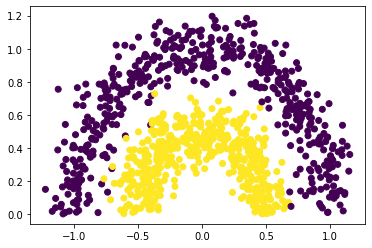

In [14]:
def generate_data(N):
    import sklearn.datasets as skld
    X,z = skld.make_circles(N, noise = 0.1, factor=0.5)
    filt =  (X[:,1] > 0)
    return X[filt],z[filt]

X,z = generate_data(2000)
plt.scatter(X[:,0],X[:,1],c = z)

We can now adapt our training code from exercise 3 (take some time to go through it, but nothing fundamental changed) and train out multilayer perceptron!


In [15]:
def loss(z,theta):
    out = np.where(z==1,-np.log(theta),-np.log(1-theta))
    grad = np.where(z==1,-1/theta,-1/(1-theta)*(-1))
    return out,grad.reshape(-1,1)

def empirical_risk(X,z,theta_func,pars):
    theta,grad_theta = theta_func(X,pars)
    loss_val,grad_loss = loss(z,theta)
    grad1 = grad_loss*grad_theta
    grad = np.concatenate([grad1], axis=-1)
    return loss_val.mean(axis=0),grad.mean(axis=0),theta

def plot(X,z,theta_func,pars):
    grid = np.mgrid[-5:5:101j,-5:5:101j]
    Xi = np.swapaxes(grid,0,-1).reshape(-1,2)   
    _,_,zi = empirical_risk(Xi,np.zeros(len(Xi)),theta_func,pars)
    zi = zi.reshape(101,101).T
    plt.contour(grid[0],grid[1],zi, levels = np.linspace(0,1,21))
    plt.scatter(X[:,0],X[:,1],c = z)
    plt.xlim(-2,2)
    plt.ylim(-2,2)

def learn(data,pars,theta_func, nsteps = 5000):
    X,z = data
    for i in range(nsteps):
        val,grad,_ = empirical_risk(X,z,theta_func,pars)
        pars = pars - 0.01*grad
        if i % (nsteps//4) == 0:
            print(val,pars)
            plot(X,z,theta_func,pars)
            plt.gcf().set_size_inches(3,3)
            plt.show()
    return pars

# Try Learning

Try learning on a dataset of 1000 samples and initialize the parameters with 

`pars = np.array([0,1,0,0,1,0,.1,.1,0])`

* Note: the point to see here is that non-linear decision boundaries are learned. 
* The learning itself, depending on the initialization might or might not be super-convincing
* Try executing this multiple times to try out different initializations
* Ultimately, we will need to add more & more neurons, but as you see the gradient calculation is painful!

0.6797871769398097 [-1.00008442e-01  1.00005857e+00 -2.38996248e-05  9.99972147e-02
  1.00005849e+00 -2.77912322e-05 -1.00594179e-01 -1.00582089e-01
  2.79020571e-04]


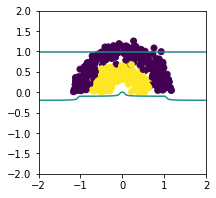

0.6003433567187545 [-0.16911886  1.18708343 -0.1439011   0.12701076  1.18141019 -0.15880389
 -0.67726793 -0.66127382  0.45447599]


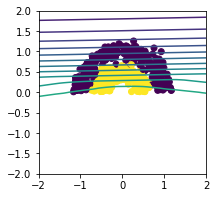

0.5240978156836901 [-0.49299801  1.40359118 -0.35111512  0.42566072  1.3982533  -0.37905245
 -1.15612815 -1.13146082  0.77192523]


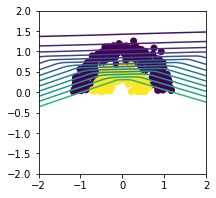

0.40667001081890924 [-1.06130156  1.53601081 -0.58138235  0.99458962  1.55864776 -0.60122292
 -1.68042661 -1.66739136  1.09721102]


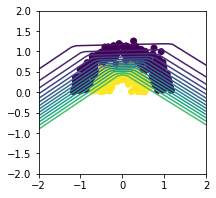

array([-1.55976501,  1.64936206, -0.79850521,  1.44964471,  1.74549012,
       -0.79403111, -2.18882829, -2.18604986,  1.55543932])

In [20]:
learn(generate_data(1000),np.array([-.1,1,0,.1,1,0,-.1,-.1,0]) ,multilayer_perceptron)


# Going to many Nodes

In [34]:
N_NODES = 10
def linear(X,pars):
    out = X @ pars[:-1].T + pars[-1]
    grad_pars = np.column_stack([X,np.ones(len(X))])
    grad_x = pars[:-1]
    return out,grad_pars, grad_x.reshape(1,-1)

def many_nodes_mlp(X,pars):
    activations = []
    grads = []
    for i in range(N_NODES):
        feature, grad_f,_ = linear(X,pars[3*i:3*(i+1)])
        activation,grad_r = relu(feature)
        activations.append(activation)
        grads.append([grad_r,grad_f])
    
    hidden = np.column_stack(activations)
    output_feature,grad_f3,grad_x = linear(hidden,pars[-(N_NODES+1):])
    theta,grad_sig = sigmoid(output_feature)
    
    grad_components = []
    for i in range(N_NODES):
        grad = grad_sig*grad_x[:,i]*grads[i][0]*grads[i][1]
        grad_components.append(grad)
    grad3 = grad_sig*grad_f3
    grad = np.concatenate(grad_components+[grad3],axis=-1)
    return theta,grad

def generate_data(N):
    import sklearn.datasets as skld
    X,z = skld.make_circles(N, noise = 0.1, factor=0.5)
    return X,z

0.8183362487948811 [-2.01407649 -0.63034942 -0.13945135  0.97411746 -0.02550904 -1.10865706
  0.45955378 -0.27018779 -0.20639377  2.48551249  0.48695488 -1.69816288
 -0.87263713 -0.07513166  0.23216015  0.73650118 -0.41139158  1.60217264
  1.15884565  0.07327227  0.24743636 -0.75041824  0.58866751 -0.72676823
  1.77340068 -0.00928501  0.86521926 -1.22625588  1.26825619  0.99754686
 -0.24425324  0.19430387  0.89087073 -0.05826832 -0.71741732  0.18309906
  0.29684606 -0.49789972  0.09339832  0.22498869  0.43638679]


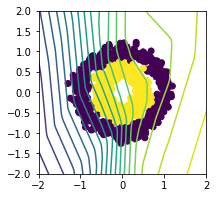

0.5400199991526125 [-2.08461661 -0.6778277  -0.22268448  0.97133386 -0.02549994 -1.11101856
  0.30447404 -0.18222974 -0.3973356   2.65215044  0.52366056 -1.50432044
 -1.01844878 -0.01151908 -0.00963755  0.71793073 -0.41877634  1.62282848
  1.14175497  0.06869115  0.21844578 -0.9301796   0.86012484 -0.41371333
  1.93934764  0.00433384  0.68911901 -1.1980817   1.18814552  1.10546748
 -0.66420525  0.19385541  0.86627846 -0.52532416 -0.85501404  0.28234272
 -0.18685247 -0.76560952 -0.5930681   0.11215162  0.57237412]


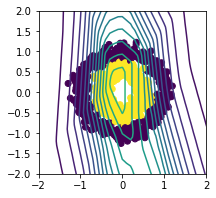

0.45199451640572286 [-2.13620694e+00 -9.26764407e-01 -2.62546567e-01  9.70492169e-01
 -2.54926325e-02 -1.11173305e+00  3.03022284e-01 -1.81747536e-01
 -3.98658920e-01  2.83784654e+00  5.82266721e-01 -1.30641681e+00
 -1.12425322e+00  9.30117077e-05 -1.10752460e-01  7.08647749e-01
 -3.77008609e-01  1.68605473e+00  1.17971805e+00  3.90296513e-02
  1.94712236e-01 -9.54684141e-01  1.28092658e+00 -2.81787788e-01
  2.05945936e+00 -9.15881500e-02  5.58680603e-01 -1.15087560e+00
  1.12692436e+00  1.23013364e+00 -1.03815253e+00  1.93735079e-01
  8.66276095e-01 -8.96684469e-01 -9.84780562e-01  4.92418241e-01
 -3.31751291e-01 -1.20064217e+00 -8.23195491e-01  2.26111615e-01
  7.35067435e-01]


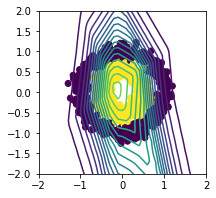

0.3484567283919273 [-2.11127169 -1.38699441 -0.27188092  0.97015685 -0.02548923 -1.11201775
  0.30302228 -0.18174754 -0.39865892  2.93710516  0.63970998 -1.26829085
 -1.20162238  0.04378493 -0.18420332  0.71003533 -0.2917903   1.75441023
  1.20616169 -0.02263076  0.17899208 -0.91342661  1.82098919 -0.23597268
  2.12649298 -0.29195372  0.49206487 -1.08170787  1.06988377  1.39883378
 -1.42886227  0.19368911  0.86627609 -1.16160741 -1.08320016  0.65010419
 -0.40775632 -1.7366544  -0.98238648  0.46359473  0.85521133]


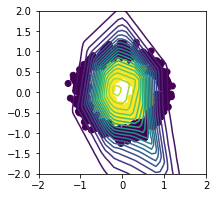

array([-2.04907739, -1.86145017, -0.29587327,  0.96996135, -0.02548788,
       -1.1121837 ,  0.30302228, -0.18174754, -0.39865892,  3.02395463,
        0.66294279, -1.25961598, -1.2860416 ,  0.09279173, -0.22755479,
        0.70962249, -0.22157684,  1.84434904,  1.23892196, -0.08080096,
        0.1488703 , -0.88905594,  2.3303747 , -0.21167888,  2.19457765,
       -0.50168351,  0.42049433, -1.03837222,  1.06500919,  1.54250238,
       -1.82693842,  0.19366263,  0.86627609, -1.36945598, -1.18653783,
        0.84243181, -0.49245211, -2.25295676, -1.16636302,  0.73161101,
        0.9761459 ])

In [35]:
learn(generate_data(1000),np.random.normal(size = (3*N_NODES+N_NODES+1)) ,multilayer_perceptron)